In [11]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, shape, MultiPolygon
import geojson
from scipy.spatial import KDTree
from geopy.distance import geodesic
import matplotlib.pyplot as plt

In [12]:
"""
# Load the datasets
parks = gpd.read_file('park_zones_dpr.geojson')
taxi_zones = gpd.read_file('nyc_taxi_zones_tlc.geojson')
green_taxi_csv = pd.read_csv('2022_green_taxi.csv', nrows=100000)

"""

"\n# Load the datasets\nparks = gpd.read_file('park_zones_dpr.geojson')\ntaxi_zones = gpd.read_file('nyc_taxi_zones_tlc.geojson')\ngreen_taxi_csv = pd.read_csv('2022_green_taxi.csv', nrows=100000)\n\n"

In [13]:
green_taxi = pd.read_csv('2022_green_taxi.csv',delimiter=';', nrows=10000)


In [14]:
green_taxi.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,01/01/2022 12:14:21 AM,01/01/2022 12:15:33 AM,N,1,42,42,1,0.44,3.5,0.50,0.5,0.00,0.0,NaN,0.3,4.80,2,1,0.00
1,1,01/01/2022 12:20:55 AM,01/01/2022 12:29:38 AM,N,1,116,41,1,2.10,9.5,0.50,0.5,0.00,0.0,NaN,0.3,10.80,2,1,0.00
2,1,01/01/2022 12:57:02 AM,01/01/2022 01:13:14 AM,N,1,41,140,1,3.70,14.5,3.25,0.5,4.60,0.0,NaN,0.3,23.15,1,1,2.75
3,2,01/01/2022 12:07:42 AM,01/01/2022 12:15:57 AM,N,1,181,181,1,1.69,8.0,0.50,0.5,0.00,0.0,NaN,0.3,9.30,2,1,0.00
4,2,01/01/2022 12:07:50 AM,01/01/2022 12:28:52 AM,N,1,33,170,1,6.26,22.0,0.50,0.5,5.21,0.0,NaN,0.3,31.26,1,1,2.75


In [15]:

# Load the GeoJSON files
with open('nyc_taxi_zones_tlc.geojson', 'r') as f:
    taxi_zones_geojson = geojson.load(f)

In [16]:

with open('park_zones_dpr.geojson', 'r') as f:
    park_zones_geojson = geojson.load(f)



In [17]:
# Filter the features based on the 'borough' property
filtered_features_taxi = [feature for feature in taxi_zones_geojson['features'] if feature['properties']['borough'] == 'Manhattan']

# Optionally convert to a DataFrame
taxi_zones_geojson['features'] = filtered_features_taxi
taxi_zones_df = pd.json_normalize(filtered_features_taxi)

# Display the first few rows of the filtered DataFrame
print(taxi_zones_df.head())

      type geometry.type                               geometry.coordinates  \
0  Feature  MultiPolygon  [[[[-73.971774, 40.725821], [-73.971791, 40.72...   
1  Feature  MultiPolygon  [[[[-73.959537, 40.798719], [-73.960045, 40.79...   
2  Feature  MultiPolygon  [[[[-74.015658, 40.704833], [-74.015398, 40.70...   
3  Feature  MultiPolygon  [[[[-74.012441, 40.719058], [-74.012816, 40.71...   
4  Feature  MultiPolygon  [[[[-73.94774, 40.8096], [-73.945061, 40.80847...   

  properties.shape_area properties.objectid properties.shape_leng  \
0     0.000111871946192                   4       0.0435665270921   
1    0.0000607235737749                  24       0.0469999619287   
2    0.0000415116236727                  12       0.0366613013579   
3     0.000149358592917                  13       0.0502813228631   
4     0.000143093037737                  41        0.052793109453   

  properties.location_id    properties.zone properties.borough  
0                      4      Alphabet City  

In [18]:
filtered_features_park = [feature for feature in park_zones_geojson['features'] if feature['properties']['borough'] == 'M']
park_zones_geojson['features'] = filtered_features_park
# Optionally convert to a DataFrame
park_zones_df = pd.json_normalize(filtered_features_park)

# Display the first few rows of the filtered DataFrame
print(park_zones_df.head())

      type geometry.type                               geometry.coordinates  \
0  Feature  MultiPolygon  [[[[-73.976235, 40.795484], [-73.976234, 40.79...   
1  Feature  MultiPolygon  [[[[-73.970957, 40.782456], [-73.971002, 40.78...   
2  Feature  MultiPolygon  [[[[-73.926807, 40.784524], [-73.926623, 40.78...   
3  Feature  MultiPolygon  [[[[-73.969931, 40.774692], [-73.970169, 40.77...   
4  Feature  MultiPolygon  [[[[-73.962353, 40.814828], [-73.962056, 40.81...   

  properties.propname properties.retireddate properties.zipcode  \
0      Riverside Park                   None              10024   
1        Central Park                   None              10024   
2   Wards Island Park                   None              10035   
3        Central Park                   None         1002310024   
4      Riverside Park                   None              10024   

  properties.acres                                properties.location  \
0         4.070674               84th To 95th Sts

In [19]:
def extract_coordinates(features):
    coordinates = []
    for feature in features:
        geom = shape(feature['geometry'])
        if isinstance(geom, MultiPolygon):
            for polygon in geom.geoms:
                for ring in polygon.exterior.coords:
                    coordinates.append((ring[1], ring[0]))  # (latitude, longitude)
        else:
            for ring in geom.exterior.coords:
                coordinates.append((ring[1], ring[0]))  # (latitude, longitude)
    return coordinates

In [20]:


# Get the coordinates for both datasets
taxi_zones_coordinates = extract_coordinates(filtered_features_taxi)
park_zones_coordinates = extract_coordinates(filtered_features_park)

# Create DataFrames to display the coordinates
taxi_zones_df = pd.DataFrame(taxi_zones_coordinates, columns=['Latitude', 'Longitude'])
park_zones_df = pd.DataFrame(park_zones_coordinates, columns=['Latitude', 'Longitude'])



In [21]:
# Convert to GeoDataFrames
taxi_gdf = gpd.GeoDataFrame(taxi_zones_df, geometry=gpd.points_from_xy(taxi_zones_df.Longitude, taxi_zones_df.Latitude))
park_gdf = gpd.GeoDataFrame(park_zones_df, geometry=gpd.points_from_xy(park_zones_df.Longitude, park_zones_df.Latitude))

In [22]:

# Set the coordinate reference system (CRS) to WGS84
taxi_gdf.set_crs(epsg=4326, inplace=True)
park_gdf.set_crs(epsg=4326, inplace=True)

,Latitude,Longitude,geometry
0,40.795484,-73.976235,POINT (-73.97624 40.79548)
1,40.795488,-73.976234,POINT (-73.97623 40.79549)
2,40.795493,-73.976234,POINT (-73.97623 40.79549)
3,40.795497,-73.976233,POINT (-73.97623 40.79550)
4,40.795501,-73.976233,POINT (-73.97623 40.79550)
...,...,...,...
84630,40.838914,-73.945645,POINT (-73.94564 40.83891)
84631,40.838949,-73.945631,POINT (-73.94563 40.83895)
84632,40.838985,-73.945620,POINT (-73.94562 40.83899)
84633,40.839021,-73.945609,POINT (-73.94561 40.83902)


In [23]:


# Display DataFrames
print("Taxi Zones Coordinates:")
print(taxi_gdf.head())



Taxi Zones Coordinates:
    Latitude  Longitude                    geometry
0  40.725821 -73.971774  POINT (-73.97177 40.72582)
1  40.725814 -73.971791  POINT (-73.97179 40.72581)
2  40.725815 -73.971817  POINT (-73.97182 40.72581)
3  40.725583 -73.971859  POINT (-73.97186 40.72558)
4  40.725503 -73.971874  POINT (-73.97187 40.72550)


In [24]:
print("\nPark Zones Coordinates:")
print(park_gdf.head())


Park Zones Coordinates:
    Latitude  Longitude                    geometry
0  40.795484 -73.976235  POINT (-73.97624 40.79548)
1  40.795488 -73.976234  POINT (-73.97623 40.79549)
2  40.795493 -73.976234  POINT (-73.97623 40.79549)
3  40.795497 -73.976233  POINT (-73.97623 40.79550)
4  40.795501 -73.976233  POINT (-73.97623 40.79550)


In [25]:
# %%
# Buffer the park points by 0.006 degrees (approximately 600 meters)
park_gdf['geometry'] = park_gdf.geometry.buffer(0.006)


C:\Users\adi17\AppData\Local\Temp\ipykernel_2256\96410569.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park_gdf['geometry'] = park_gdf.geometry.buffer(0.006)


In [26]:
# Merge the green taxi data with the location data using PULocationID and DOLocationID
taxi_zones_df['location_id'] = taxi_zones_df.index + 1  # Assuming index + 1 as location_id
green_taxi = green_taxi.rename(columns={'PULocationID': 'PUlocationID', 'DOLocationID': 'DOlocationID'})


In [27]:
# Merge with pickup locations
pickup_locations = green_taxi.merge(taxi_zones_df, left_on='PUlocationID', right_on='location_id')

# Merge with dropoff locations
dropoff_locations = green_taxi.merge(taxi_zones_df, left_on='DOlocationID', right_on='location_id')


In [28]:
# Create GeoDataFrames for pickup and dropoff locations
pickup_gdf = gpd.GeoDataFrame(pickup_locations, geometry=gpd.points_from_xy(pickup_locations.Longitude, pickup_locations.Latitude))
dropoff_gdf = gpd.GeoDataFrame(dropoff_locations, geometry=gpd.points_from_xy(dropoff_locations.Longitude, dropoff_locations.Latitude))



In [29]:
# Set the coordinate reference system (CRS) to WGS84
pickup_gdf.set_crs(epsg=4326, inplace=True)
dropoff_gdf.set_crs(epsg=4326, inplace=True)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PUlocationID,DOlocationID,passenger_count,trip_distance,fare_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Latitude,Longitude,location_id,geometry
0,2,01/01/2022 12:14:21 AM,01/01/2022 12:15:33 AM,N,1,42,42,1,0.44,3.5,...,NaN,0.3,4.80,2,1,0.00,40.719079,-73.976092,42,POINT (-73.97609 40.71908)
1,1,01/01/2022 12:20:55 AM,01/01/2022 12:29:38 AM,N,1,116,41,1,2.10,9.5,...,NaN,0.3,10.80,2,1,0.00,40.718959,-73.975510,41,POINT (-73.97551 40.71896)
2,1,01/01/2022 12:57:02 AM,01/01/2022 01:13:14 AM,N,1,41,140,1,3.70,14.5,...,NaN,0.3,23.15,1,1,2.75,40.798719,-73.959537,140,POINT (-73.95954 40.79872)
3,2,01/01/2022 12:07:42 AM,01/01/2022 12:15:57 AM,N,1,181,181,1,1.69,8.0,...,NaN,0.3,9.30,2,1,0.00,40.700629,-74.014297,181,POINT (-74.01430 40.70063)
4,2,01/01/2022 12:07:50 AM,01/01/2022 12:28:52 AM,N,1,33,170,1,6.26,22.0,...,NaN,0.3,31.26,1,1,2.75,40.700395,-74.014137,170,POINT (-74.01414 40.70040)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,01/06/2022 03:36:42 PM,01/06/2022 03:50:38 PM,N,1,181,188,1,2.07,11.0,...,NaN,0.3,11.80,2,1,0.00,40.700308,-74.014584,188,POINT (-74.01458 40.70031)
9996,2,01/06/2022 03:07:59 PM,01/06/2022 03:20:25 PM,N,1,116,24,1,1.87,10.5,...,NaN,0.3,11.30,2,1,0.00,40.723312,-73.972361,24,POINT (-73.97236 40.72331)
9997,2,01/06/2022 03:47:05 PM,01/06/2022 04:07:13 PM,N,1,41,200,1,8.54,25.5,...,NaN,0.3,38.09,1,1,0.00,40.700462,-74.014479,200,POINT (-74.01448 40.70046)
9998,2,01/06/2022 03:44:23 PM,01/06/2022 03:54:36 PM,N,1,42,41,1,1.23,8.0,...,NaN,0.3,11.44,1,1,0.00,40.718959,-73.975510,41,POINT (-73.97551 40.71896)


In [30]:
# Perform spatial joins to find nearby pickups and drop-offs
nearby_pickups = gpd.sjoin(pickup_gdf, park_gdf, how='inner', op='within')
nearby_dropoffs = gpd.sjoin(dropoff_gdf, park_gdf, how='inner', op='within')

# %%
# Calculate busyness by summing the passenger counts
pickup_busyness = nearby_pickups.groupby(['Latitude_right', 'Longitude_right', 'lpep_pickup_datetime'])['passenger_count'].sum().reset_index(name='Pickup_Passenger_Count')
dropoff_busyness = nearby_dropoffs.groupby(['Latitude_right', 'Longitude_right', 'lpep_dropoff_datetime'])['passenger_count'].sum().reset_index(name='Dropoff_Passenger_Count')
#FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  #if await self.run_code(code, result, async_=asy):


c:\Users\adi17\anaconda3\envs\comp47350py311\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\adi17\anaconda3\envs\comp47350py311\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [31]:

# Merge the busyness data
busyness_df = pd.merge(pickup_busyness, dropoff_busyness, on=['Latitude_right', 'Longitude_right'], how='outer', suffixes=('_pickup', '_dropoff'))

# Display the busyness DataFrame
print("Busyness around parks within 600 meters:")
print(busyness_df.head())


MemoryError: Unable to allocate 127. GiB for an array with shape (17023915920,) and data type int64

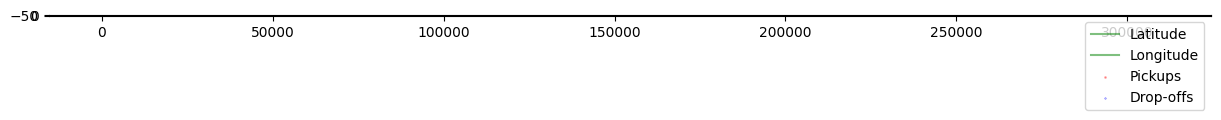

In [ ]:
# Plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 15))
base = park_zones_df.plot(ax=ax, color='green', alpha=0.5)
pickup_gdf.plot(ax=base, marker='o', color='red', markersize=1, alpha=0.3, label='Pickups')
dropoff_gdf.plot(ax=base, marker='x', color='blue', markersize=1, alpha=0.3, label='Drop-offs')
plt.legend()
plt.show()

In [ ]:
import folium

m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)

# Add park zones to the map
for _, park in park_zones_df.iterrows():
    folium.GeoJson(park['geometry'], style_function=lambda x: {'color': 'green', 'weight': 2, 'fillOpacity': 0.5}).add_to(m)

# Add pickup and dropoff points
for _, row in pickup_gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=1, color='red', fill=True).add_to(m)

for _, row in dropoff_gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=1, color='blue', fill=True).add_to(m)

# Save or display the map
m.save('manhattan_taxi_parks.html')

KeyError: 'geometry'

In [15]:
"""# Use KDTree for fast nearest-neighbor lookup
taxi_coords = taxi_zones_df[['Latitude', 'Longitude']].to_numpy()
park_coords = park_zones_df[['Latitude', 'Longitude']].to_numpy()
"""

In [16]:
"""tree = KDTree(taxi_coords)

# Find all park coordinates within 600 meters of any taxi coordinate
results = tree.query_ball_point(park_coords, r=0.006)
"""

In [17]:
"""#Distance geodesic 
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2))
    """

'#Distance geodesic \ndef calculate_distance(lat1, lon1, lat2, lon2):\n    return geodesic((lat1, lon1), (lat2, lon2))\n    '

In [18]:
# Function to calculate the Euclidean distance
def calculate_distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2)


In [19]:

# Initialize an empty list to store distances and filtered pairs
filtered_pairs = []

# Iterate over the results and store the pairs
for park_index, taxi_indices in enumerate(results):
    park_lat, park_lon = park_coords[park_index]
    for taxi_index in taxi_indices:
        taxi_lat, taxi_lon = taxi_coords[taxi_index]
        dist = calculate_distance(park_lat, park_lon,taxi_lat, taxi_lon,)
        filtered_pairs.append({
            'Taxi_Latitude': taxi_lat,
            'Taxi_Longitude': taxi_lon,
            'Park_Latitude': park_lat,
            'Park_Longitude': park_lon,
            'Distance': dist
        })



In [20]:
"""for park_index, taxi_indices in enumerate(results):
    park_lat, park_lon = park_coords[park_index]
    for taxi_index in taxi_indices:
        taxi_lat, taxi_lon = taxi_coords[taxi_index]
        dist = geodesic((taxi_lat, taxi_lon), (park_lat, park_lon))
        if dist <= 600:  # 600 meters
            filtered_pairs.append({
                'Taxi_Latitude': taxi_lat,
                'Taxi_Longitude': taxi_lon,
                'Park_Latitude': park_lat,
                'Park_Longitude': park_lon,
                'Distance': dist
            })
        """

"for park_index, taxi_indices in enumerate(results):\n    park_lat, park_lon = park_coords[park_index]\n    for taxi_index in taxi_indices:\n        taxi_lat, taxi_lon = taxi_coords[taxi_index]\n        dist = geodesic((taxi_lat, taxi_lon), (park_lat, park_lon))\n        if dist <= 600:  # 600 meters\n            filtered_pairs.append({\n                'Taxi_Latitude': taxi_lat,\n                'Taxi_Longitude': taxi_lon,\n                'Park_Latitude': park_lat,\n                'Park_Longitude': park_lon,\n                'Distance': dist\n            })\n        "

FOR FUTURE 

In [21]:
# Create a DataFrame for filtered pairs within 600 meters
filtered_df_600metres = pd.DataFrame(filtered_pairs)



In [22]:
# Save the filtered DataFrame to a CSV file
#filtered_df.to_csv('filtered_pairs_within_600_meters.csv', index=False)
#print("Filtered data saved to 'filtered_pairs_within_600_meters.csv'")


In [23]:
# Display the filtered DataFrame
print("Filtered Pairs within 600 meters:")
print(filtered_df_600metres)

Filtered Pairs within 600 meters:
          Taxi_Latitude  Taxi_Longitude  Park_Latitude  Park_Longitude  \
0             40.623202      -74.095335      40.627721      -74.099146   
1             40.623202      -74.095335      40.627721      -74.099146   
2             40.622329      -74.096400      40.627750      -74.098925   
3             40.623202      -74.095335      40.627750      -74.098925   
4             40.623202      -74.095335      40.627750      -74.098925   
...                 ...             ...            ...             ...   
31919650      40.559005      -74.099296      40.564116      -74.097017   
31919651      40.558964      -74.099380      40.564116      -74.097017   
31919652      40.559141      -74.099718      40.564116      -74.097017   
31919653      40.559071      -74.099929      40.564116      -74.097017   
31919654      40.559071      -74.099929      40.564116      -74.097017   

          Distance  
0         0.005911  
1         0.005911  
2         0.00

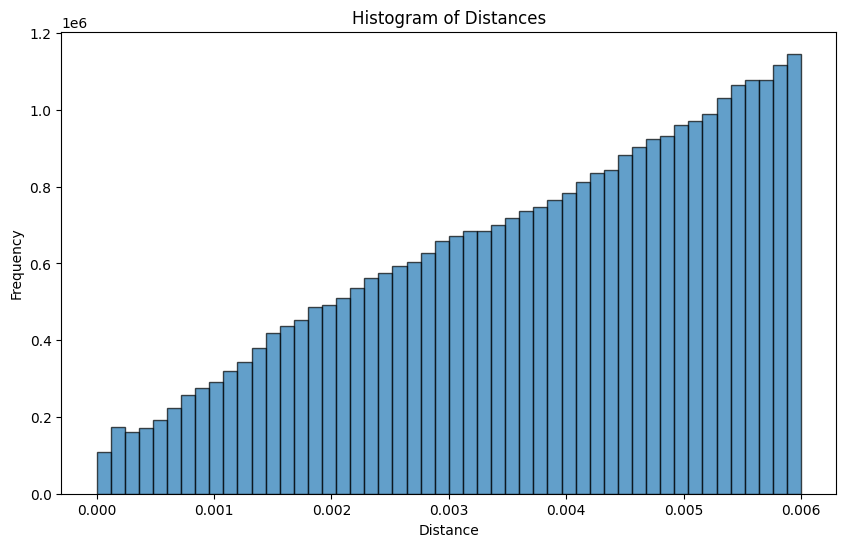

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(filtered_df_600metres['Distance'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Merge the green taxi data with the location data using PULocationID and DOLocationID
taxi_zones_df['location_id'] = taxi_zones_df.index + 1  #create a unique identifier for each row.
green_taxi = green_taxi.rename(columns={'PULocationID': 'PUlocationID', 'DOLocationID': 'DOlocationID'})

# Merge with pickup locations
pickup_locations = green_taxi.merge(taxi_zones_df, left_on='PUlocationID', right_on='location_id')

# Merge with dropoff locations
dropoff_locations = green_taxi.merge(taxi_zones_df, left_on='DOlocationID', right_on='location_id')

In [26]:
#Create GeoDataFrames for pickup and dropoff locations
pickup_gdf = gpd.GeoDataFrame(pickup_locations, geometry=gpd.points_from_xy(pickup_locations.Longitude, pickup_locations.Latitude))
dropoff_gdf = gpd.GeoDataFrame(dropoff_locations, geometry=gpd.points_from_xy(dropoff_locations.Longitude, dropoff_locations.Latitude))

In [27]:
print(pickup_gdf.head())

   VendorID    lpep_pickup_datetime   lpep_dropoff_datetime  \
0         2  01/01/2022 12:14:21 AM  01/01/2022 12:15:33 AM   
1         1  01/01/2022 12:20:55 AM  01/01/2022 12:29:38 AM   
2         1  01/01/2022 12:57:02 AM  01/01/2022 01:13:14 AM   
3         2  01/01/2022 12:07:42 AM  01/01/2022 12:15:57 AM   
4         2  01/01/2022 12:07:50 AM  01/01/2022 12:28:52 AM   

  store_and_fwd_flag  RatecodeID  PUlocationID  DOlocationID  passenger_count  \
0                  N           1            42            42                1   
1                  N           1           116            41                1   
2                  N           1            41           140                1   
3                  N           1           181           181                1   
4                  N           1            33           170                1   

   trip_distance  fare_amount  ...  ehail_fee  improvement_surcharge  \
0           0.44          3.5  ...        NaN                 

In [28]:
print(dropoff_gdf.head())

   VendorID    lpep_pickup_datetime   lpep_dropoff_datetime  \
0         2  01/01/2022 12:14:21 AM  01/01/2022 12:15:33 AM   
1         1  01/01/2022 12:20:55 AM  01/01/2022 12:29:38 AM   
2         1  01/01/2022 12:57:02 AM  01/01/2022 01:13:14 AM   
3         2  01/01/2022 12:07:42 AM  01/01/2022 12:15:57 AM   
4         2  01/01/2022 12:07:50 AM  01/01/2022 12:28:52 AM   

  store_and_fwd_flag  RatecodeID  PUlocationID  DOlocationID  passenger_count  \
0                  N           1            42            42                1   
1                  N           1           116            41                1   
2                  N           1            41           140                1   
3                  N           1           181           181                1   
4                  N           1            33           170                1   

   trip_distance  fare_amount  ...  ehail_fee  improvement_surcharge  \
0           0.44          3.5  ...        NaN                 

In [29]:
# Set the coordinate reference system (CRS) to WGS84
pickup_gdf.set_crs(epsg=4326, inplace=True)
dropoff_gdf.set_crs(epsg=4326, inplace=True)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PUlocationID,DOlocationID,passenger_count,trip_distance,fare_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,Latitude,Longitude,location_id,geometry
0,2,01/01/2022 12:14:21 AM,01/01/2022 12:15:33 AM,N,1,42,42,1,0.44,3.5,...,NaN,0.3,4.80,2,1,0.00,40.707470,-74.175381,42,POINT (-74.17538 40.70747)
1,1,01/01/2022 12:20:55 AM,01/01/2022 12:29:38 AM,N,1,116,41,1,2.10,9.5,...,NaN,0.3,10.80,2,1,0.00,40.707380,-74.175660,41,POINT (-74.17566 40.70738)
2,1,01/01/2022 12:57:02 AM,01/01/2022 01:13:14 AM,N,1,41,140,1,3.70,14.5,...,NaN,0.3,23.15,1,1,2.75,40.680875,-74.169954,140,POINT (-74.16995 40.68088)
3,2,01/01/2022 12:07:42 AM,01/01/2022 12:15:57 AM,N,1,181,181,1,1.69,8.0,...,NaN,0.3,9.30,2,1,0.00,40.672028,-74.182140,181,POINT (-74.18214 40.67203)
4,2,01/01/2022 12:07:50 AM,01/01/2022 12:28:52 AM,N,1,33,170,1,6.26,22.0,...,NaN,0.3,31.26,1,1,2.75,40.671317,-74.177784,170,POINT (-74.17778 40.67132)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,01/06/2022 03:36:42 PM,01/06/2022 03:50:38 PM,N,1,181,188,1,2.07,11.0,...,NaN,0.3,11.80,2,1,0.00,40.673909,-74.185479,188,POINT (-74.18548 40.67391)
9996,2,01/06/2022 03:07:59 PM,01/06/2022 03:20:25 PM,N,1,116,24,1,1.87,10.5,...,NaN,0.3,11.30,2,1,0.00,40.704392,-74.181807,24,POINT (-74.18181 40.70439)
9997,2,01/06/2022 03:47:05 PM,01/06/2022 04:07:13 PM,N,1,41,200,1,8.54,25.5,...,NaN,0.3,38.09,1,1,0.00,40.680794,-74.189700,200,POINT (-74.18970 40.68079)
9998,2,01/06/2022 03:44:23 PM,01/06/2022 03:54:36 PM,N,1,42,41,1,1.23,8.0,...,NaN,0.3,11.44,1,1,0.00,40.707380,-74.175660,41,POINT (-74.17566 40.70738)


In [ ]:
# %%
# Perform spatial joins to find nearby pickups and drop-offs
nearby_pickups = gpd.sjoin(pickup_gdf, park_gdf, how='inner', op='within')
nearby_dropoffs = gpd.sjoin(dropoff_gdf, park_gdf, how='inner', op='within')



In [ ]:
# %%
# Calculate busyness by summing the passenger counts
busyness = nearby_pickups.groupby(['Latitude_right', 'Longitude_right'])['passenger_count'].sum().reset_index(name='Pickup_Passenger_Count')
dropoff_busyness = nearby_dropoffs.groupby(['Latitude_right', 'Longitude_right'])['passenger_count'].sum().reset_index(name='Dropoff_Passenger_Count')

# Merge the busyness data
busyness_df = pd.merge(busyness, dropoff_busyness, on=['Latitude_right', 'Longitude_right'], how='outer').fillna(0)
busyness_df['Total_Passenger_Count'] = busyness_df['Pickup_Passenger_Count'] + busyness_df['Dropoff_Passenger_Count']


In [30]:
"""# Assess busyness by calculating the sum of passenger counts within the 600-meter radius
busyness = []
for idx, row in filtered_df_600metres.iterrows():
    park_point = Point(row['Park_Longitude'], row['Park_Latitude'])
    buffer = park_point.buffer(0.006)
    nearby_pickups = pickup_gdf[pickup_gdf.geometry.within(buffer)]
    nearby_dropoffs = dropoff_gdf[dropoff_gdf.geometry.within(buffer)]
    total_passengers = nearby_pickups['passenger_count'].sum() + nearby_dropoffs['passenger_count'].sum()
    busyness.append({
        'Park_Latitude': row['Park_Latitude'],
        'Park_Longitude': row['Park_Longitude'],
        'Total_Passenger_Count': total_passengers,
        'Pickup_Count': len(nearby_pickups),
        'Dropoff_Count': len(nearby_dropoffs)
    })
"""

KeyboardInterrupt: 

In [ ]:
# Create a DataFrame to display the busyness around parks
busyness_df = pd.DataFrame(busyness)

# Display the busyness DataFrame
print("Busyness around parks within 600 meters:")
print(busyness_df.head())

In [ ]:
# %%
# Plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 15))
base = park_zones_df.plot(ax=ax, color='green', alpha=0.5)
pickup_gdf.plot(ax=base, marker='o', color='red', markersize=1, alpha=0.3, label='Pickups')
dropoff_gdf.plot(ax=base, marker='x', color='blue', markersize=1, alpha=0.3, label='Drop-offs')
plt.legend()
plt.show()

In [ ]:
import folium

m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)

In [ ]:
# Add park zones to the map
for _, park in park_zones_df.iterrows():
    folium.GeoJson(park['geometry'], style_function=lambda x: {'color': 'green', 'weight': 2, 'fillOpacity': 0.5}).add_to(m)

# Add pickup and dropoff points
for _, row in pickup_gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=1, color='red', fill=True).add_to(m)

for _, row in dropoff_gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=1, color='blue', fill=True).add_to(m)


In [ ]:
# Save or display the map
m.save('manhattan_taxi_parks.html')